# Solving the Maximum Cut Problem with QAOA, PennyLane and Amazon Braket Hybrid Jobs

In this tutorial, we solve a max-cut problem with the Quantum Approximate Optimization Algorithm (QAOA) implemented using PennyLane and running on Amazon Braket Hybrid Jobs. Additional learning resources for this use case can be found in the [Braket Tutorials GitHub repository](https://github.com/amazon-braket/amazon-braket-examples):

* This notebook builds upon [`Using_PennyLane_with_Braket_Jobs.ipynb`](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_jobs/2_Using_PennyLane_with_Braket_Hybrid_Jobs/Using_PennyLane_with_Braket_Hybrid_Jobs.ipynb). 
* A general introduction to QAOA and a reference implementation using Braket SDK circuit constructs can be found in [`QAOA_braket.ipynb`](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb).
* Additional information on how to use PennyLane for QAOA can be found in [`2_Graph_optimization_with_QAOA.ipynb`](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/pennylane/2_Graph_optimization_with_QAOA/2_Graph_optimization_with_QAOA.ipynb).

## Problem Definition

In a graph $G$ with vertices $V$ and edges $E$, the [**maximum cut**](https://en.wikipedia.org/wiki/Maximum_cut) is a partition of the vertices into two complimentary subsets $S$ and $T$, such that the number of edges between $S$ and $T$ is maximal. Finding such cut is known as the max-cut problem - an NP-hard combinatorial optimization problem.

<br>
<div align="center">
<figure style="display: inline-block">
<img src="images/max-cut.svg" width="200"/>
<figcaption>
    <i>Example of a maximum cut</i>, <br> Wikimedia Commons, <br> <a href="https://commons.wikimedia.org/wiki/File:Max-cut.svg">File:Max-cut.svg</a>
</figcaption>
</figure>
</div>
    
## Quantum Approximate Optimization Algorithm (QAOA)

The [Quantum Approximate Optimization Algorithm (QAOA)](https://arxiv.org/abs/1411.4028) can be used to (approximately) solve the max-cut problem. QAOA belongs to the class of hybrid quantum algorithms (leveraging both classical as well as quantum compute resources), that are widely believed to be the working horse for the current NISQ (noisy intermediate-scale quantum) era.

<div align="center">
<figure style="display: inline-block">
<img src="images/qaoa.png" width="900"/>
</figure>
</div>

## Example Problem

To get started, we first create and visualize a random graph for the max-cut problem with the <code>networkx</code> package. Feel free to adjust the number of nodes, <code>num_nodes</code>, and number of edges, <code>num_edges</code> as part of your experiments.

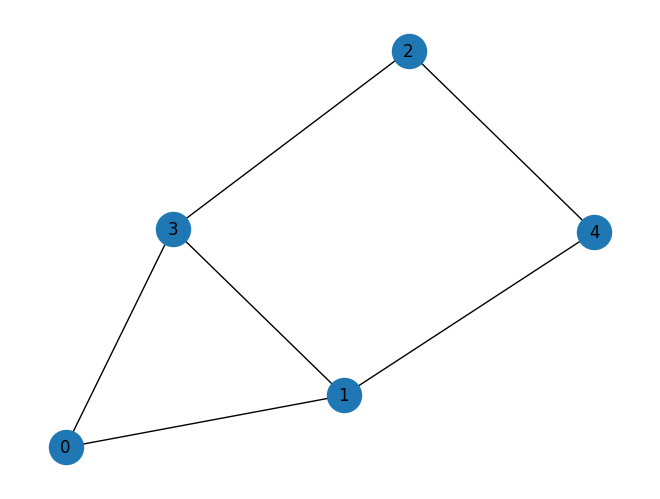

In [1]:
# 이 코드는 5개의 노드와 6개의 엣지를 가진 무작위 그래프를 생성하고, 이를 시각화하여 보여줍니다

# networks 라이브러리 사용하여 무작위 그래프를 생성하고 시각화 
# NetworkX 라이브러리를 임포트, NetworkX는 Python에서 그래프와 네트워크를 생성, 조작 및 연구하기 위한 패키지
import networkx as nx

# We generate a random graph with num_nodes nodes and num_edges edges to run Max-Cut on.
# num_nodes is the number of nodes in your graph, each represented by one qubit.
# Caution: Circuit runtimes will scale exponentially with num_nodes
num_nodes = 5
num_edges = 6
#난수 생성을 위한 시드 값을 정의
seed = 1985

# nx.gnm_random_graph 함수를 사용하여 무작위 그래프를 생성
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
# nx.spring_layout 함수를 사용하여 그래프의 노드 위치를 계산
positions = nx.spring_layout(graph, seed=seed)

# nx.draw 함수를 사용하여 그래프를 시각화합니다. with_labels=True는 노드에 레이블을 표시하도록 합니다. 
# pos=positions는 계산된 노드 위치를 사용합니다. node_size=600은 노드의 크기를 600으로 설정합니다
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

We store the graph for later in [adjacency-list format](https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.adjlist.write_adjlist.html):

In [2]:
# 이 부분을 실행하면 실제로 graph.adlist라는 파일이 생성된다
# 이 코드는 NetworkX 라이브러리에서 생성된 graph 객체를 "graph.adjlist" 파일에 인접 리스트 형식으로 저장하는 역할

# input_file_path라는 변수를 생성하고, 그 값으로 "graph.adjlist"를 할당합니다. 이는 그래프 데이터를 저장할 파일의 경로와 이름을 나타냄
input_file_path = "graph.adjlist"

# nx.write_adjlist() 함수는 NetworkX 라이브러리에서 제공하는 함수로 그래프 데이터를 인접 리스트(adjacency list) 형식으로 파일에 저장
# 첫 번째 인자 graph는 저장할 그래프 객체
# 두 번째 인자 input_file_path는 그래프 데이터를 저장할 파일의 경로와 이름을 지정합니다. 이 코드에서는 "graph.adjlist" 파일에 저장
nx.write_adjlist(graph, input_file_path)

## Example Algorithm Implementation 

Let's review the algorithm code we are going to use for solving the max-cut problem with QAOA implemented [here](maxcut_qaoa.py). The example implementation uses the [PennyLane QAOA module](https://docs.pennylane.ai/en/stable/code/qml_qaoa.html) which provides a collection of convenient methods that help in the construction of QAOA workflows.

To find a solution to the max-cut problem, QAOA approximates the ground state of the cost Hamiltonian $H_C = \frac{1}{2} \sum_{i,j\in E}\left(I-\sigma_i^Z \sigma_j^Z \right)$ by preparing the parametrized ansatz

$$
|\beta, \gamma\rangle = U_{x}(\beta_p)U_{ZZ}(\gamma_p)U_{x}(\beta_{p-1})U_{ZZ}(\gamma_{p-1})...U_{x}(\beta_1)U_{ZZ}(\gamma_1)
$$

consisting of $p$ layers of unitaries 

$$U_{x}(\beta) = \exp\left[-i\beta\sum_i\sigma_i^x\right]$$ 

and 

$$U_{ZZ}(\gamma) = \exp\left[-i\gamma H_C\right]$$ 

starting from a uniform superposition of the basis states $|+,+,...,+\rangle$.

<div align="center">
<figure style="display: inline-block">
<img src="images/qaoa_circuit.png" width="600"/>
<figcaption>
    <i>Example QAOA circuits with 2 qubits and 2 layers</i>
</figcaption>
</figure>
</div>

State preparation is followed by a measurement in computational basis with several shots to evaluate the expectation value $E(\beta, \gamma) = \langle H_C \rangle$. A classical optimizer varies the $2p$ free parameters to minimize $E(\beta, \gamma)$.

## Local Execution

We can run the algorithm locally in this notebook and only use the compute resources of the managed notebook instance. Quantum circuits can be processed on a local simulator.
In this case, there is no communication with Braket service APIs. 
The optimization job is running interactively and exists only within the session of this program.

<div align="center">
    <img src="images/job_local.png" width="600"/>
</div>

하이브리드 환경을 필요로 하는 것은 맞지만 amazon hybrid job 기능을 사용 안한 환경

고전 컴퓨터 리소스: 주피터 노트북 탑재 EC2, 양자 컴퓨팅 리소스: 페니레인 로컬 시뮬레이터; 즉 양자 리소스, 고전 컴퓨팅 리소스 모두 주피터 노트북 인스턴스 사용

위에서 알고리즘 코드가 maxcut_qaoa.py 임
인풋 데이터가 graph.adjlist 임

In [5]:
# 이 코드는 QAOA 알고리즘을 실행하기 위한 준비 단계로, 로컬 시뮬레이터를 사용하여 주어진 그래프의 노드 수만큼의 큐비트를 가진 양자 디바이스를 설정합니다. 
# 이후 이 device를 사용하여 QAOA 알고리즘을 실행할 수 있습니다.

# maxcut_qaoa 파일에서 run_qaoa와 get_device_instance 함수를 가져옵니다
from maxcut_qaoa import run_qaoa, get_device_instance

In [ ]:
# 페니레인 로컬 시뮬레이터 
# get_device_instance 함수는 PennyLane에서 제공하는 함수
device = get_device_instance(
    # local은 로컬 시뮬레이터를 사용한다는 의미이며, pennylane/lightning.qubit은 Lightning 플러그인의 PennyLane의 로컬 시뮬레이터를 사용하겠다는 의미.
    # lightning.qubit은 PennyLane의 고성능 상태 벡터 시뮬레이터로 CPU 기반 시뮬레이터 
    # 하이브리드 환경이 지정 되어있지 않기 때문에, 주피터 노트북에서 실행됨
    # PennyLane의 lightning.qubit 시뮬레이터는 코드의 실행 컨텍스트에 따라 실행 위치가 결정됩니다.
    "local:pennylane/lightning.qubit",
    
    # 이 매개변수는 생성할 큐비트의 수를 지정
    n_wires=len(graph.nodes)
)

## Running with Braket Hybrid Jobs

Instead of running the optimization interactively, we now want to create a Braket Hybrid Job.

**Amazon Braket Hybrid Jobs** offers an easy way to run algorithms requiring both classical AWS resources and quantum processing units (QPUs) in a fully managed environment. When you create a job, the service spins up the requested classical compute resources, runs your algorithm, and releases the instances after completion.

Additionally, quantum tasks created from a hybrid job benefit from higher priority queueing to a target QPU. This ensures your quantum tasks are processed and executed ahead of others in the queue. This is particularly beneficial for iterative hybrid algorithms where subsequent tasks depend on the outcomes of prior quantum tasks.

Find more information on Amazon Braket Hybrid Jobs in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) and the [SDK documentation](https://amazon-braket-sdk-python.readthedocs.io/en/latest/index.html).

### Running the above example as a hybrid job

The above example does not use a Braket simulator backend or QPU for training. Instead, a local simulator - in this case, a PennyLane simulator - is used. Even in this case, it's benefitial to run this job as a Hybrid Job on Braket because 

* we can create a remote job and don't need to keep an interactive session running during the length of the training
* we can choose then classical compute instance type most suitable for our classical compute requirements (in terms of CPU, RAM, GPU, etc.)

When we are running a Hybrid Job which uses a local simulator for quantum tasks, the local simulator in embedded in the job container.

Input data your job need to run can be sent along during job creation. Alternatively, data can be uploaded upfront and later referenced during job creation.

<div align="center">
<img src="images/job_hybrid_embedded.png" width="1000"/>
</div>

In order to run our optimization as a Hybrid Job, we create a wrapper function which will run on the job instance and prepares the inputs to our algorithm function `run_qaoa`.
Hyperparameters are specified as function arguments and we annotate the function with the `@hybrid_job` decorator. 

Then, we create a hybrid job by invoking the function.

In the decorator, we can specify, for instance, 
- on which device we want to execute the quantum tasks
- Python modules we want to make available at job runtime, for exampe containing our algorithm code
- the relative path to the input file containing the edge list of our graph

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

# hybrid_job: Amazon Braket에서 하이브리드 양자-고전 작업을 정의하는 데 사용되는 함수
# save_job_result: 작업의 결과를 저장하는 데 사용되는 함수입니다. 이 함수는 실행된 작업의 결과를 파일로 저장하는 데 유용
from braket.jobs import hybrid_job, save_job_result
from braket.tracking import Tracker
# get_input_data_dir: 작업에 대한 입력 데이터가 저장된 디렉토리를 가져오는 함수
# get_results_dir: 작업 결과가 저장될 디렉토리를 가져오는 함수
# get_job_device_arn: 현재 작업에서 사용되는 장치의 ARN(Amazon Resource Name)을 가져오는 함수
from braket.jobs.environment_variables import get_job_name, get_input_data_dir, get_results_dir, get_job_device_arn

#  PennyLane의 lightning.qubit 시뮬레이터를 사용하기 위해 장치 ARN을 설정
device_arn = "local:pennylane/lightning.qubit"

# 이 줄은 hybrid_job이라는 데코레이터를 사용하여 함수를 하이브리드 양자-고전 작업으로 정의
@hybrid_job(
    device=device_arn,
    input_data=input_file_path,
    include_modules="maxcut_qaoa"
)
# 이 코드는 Pennylane 라이브러리를 사용하여 QAOA(Quantum Approximate Optimization Algorithm) 알고리즘을 구현하는 함수
# num_iterations=20: 최적화 반복 횟수를 설정합니다. 기본값은 20
# max_parallel=25: 최대 병렬 실행 수를 설정합니다. 기본값은 25
# step_size=0.01: 경사 하강법에서 사용할 학습률(스텝 사이즈)입니다. 기본값은 0.01
# •	shots=1000: 양자 회로의 측정 샷 수를 설정합니다. 기본값은 1000
def qaoa_maxcut_pennylane(p=2, max_parallel=25, num_iterations=20, step_size=0.01, shots=1000):
    print(f"{get_job_name()} execution started")
    cost_tracker = Tracker().start()

    # Read graph from input file
    # get_input_data_dir() 함수를 호출하여 입력 데이터 디렉토리 경로를 가져옵니다
    input_dir = get_input_data_dir()
    # nx.read_adjlist() 함수를 사용하여 graph.adjlist 파일에서 그래프 데이터를 읽어옵니다. 이 때 nodetype=int를 지정하여 노드 값을 정수형으로 해석
    # 읽어온 그래프 데이터를 g 변수에 할당
    g = nx.read_adjlist(f"{input_dir}/graph.adjlist", nodetype=int)
    # 마지막으로 print(f"Graph loaded: {g}") 문을 통해 그래프가 성공적으로 로드되었음을 출력합니다.
    print(f"Graph loaded: {g}")

    # Instantiate device
    #이 설정을 통해 하이브리드 잡에서 사용할 양자 디바이스의 구성 정의
    # get_device_instance(...) 함수를 호출하여 양자 장치 인스턴스를 생성
    device = get_device_instance(
        # get_job_device_arn()은 현재 작업에서 사용되는 장치의 ARN(Amazon Resource Name)을 반환
        get_job_device_arn(),
        n_wires=len(g.nodes),
        n_shots=shots,
        max_parallel=max_parallel
    )

    # Run algorithm
    # 아래 2개의 값 반환
    # optimized_parameters는 QAOA 알고리즘을 통해 최적화된 파라미터 값
    # sampled_probs는 QAOA 알고리즘에 의해 계산된 확률 분포, 각 비트 문자열에 대한 샘플링된 확률 분포
    optimized_parameters, sampled_probs = run_qaoa(
        graph=g,
        device=device,
        p=p,
        n_iterations=num_iterations,
        step_size=step_size
    )

    # Draw graph to an output file
    output_dir = get_results_dir()
    
    # NetworkX 라이브러리를 사용하여 그래프 g를 시각화
    nx.draw(g, with_labels=True, node_size=600)
    
    # Matplotlib를 사용하여 시각화된 그래프를 output_dir 디렉터리에 "graph.png" 파일로 저장합니다
    plt.savefig(f"{output_dir}/graph.png")

    cost_tracker.stop()

    return {
        # optimized_parameters는 최적화된 양자 회로의 파라미터를 나타냅니다
        "parameters": optimized_parameters.tolist(),
        
        # sampled_probs는 양자 회로에서 측정된 결과로부터 계산된 확률 분포
        "sampled probs": sampled_probs,
        
        # 양자 작업 요약
        "quantum task summary": cost_tracker.quantum_tasks_statistics(),
        "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
    }

#Amazon Braket을 사용하여 QAOA를 실행하는 작업(job)을 생성하고, 해당 작업의 ARN(Amazon Resource Name)과 상태를 출력
# qaoa_maxcut_pennylane(num_iterations=40) 함수는 PennyLane라이브러리를 사용하여 MaxCut 문제를 풀기 위한 QAOA를 40번의 반복으로 설정
# 작업 실행 트리거: 이 라인은 @hybrid_job 데코레이터로 정의된 함수를 실제로 호출하여 Amazon Braket Hybrid Jobs 서비스에 작업을 제출합니다.
job = qaoa_maxcut_pennylane(num_iterations=40)
print(f"{job.arn} {job.state()}")

arn:aws:braket:us-east-1:013288819788:job/8e7e404a-d180-4385-b960-841c67a073ac QUEUED


### Job Status

Let check the job status and wait until the job completes.

In [13]:
job.state()

'COMPLETED'

### Job Metadata

While the job is running we have access to the job metadata:

In [7]:
# job.metadata() 메서드는 현재 작업에 대한 메타데이터를 반환하고, 반환된 메타데이터는 job_metadata 변수에 저장
job_metadata = job.metadata()

# 작업이 생성된 시간을 나타냅니다. 이 정보는 작업이 언제 시작되었는지를 확인하는 데 유용
print(f"Created: {job.metadata()['createdAt']}")

# 작업이 실행되는 양자 장치의 ARN(Amazon Resource Name)을 가져옵니다
device_arn = job_metadata['deviceConfig']['device']
print(f"Quantum tasks running on device: {device_arn}")

# 작업에 사용된 하이퍼파라미터를 가져옵니다
hyperparameters = job_metadata['hyperParameters']
print(f"Hyperparameters: {hyperparameters}")

Created: 2025-03-23 07:30:07.370000+00:00
Quantum tasks running on device: local:pennylane/lightning.qubit
Hyperparameters: {'p': '2', 'max_parallel': '25', 'num_iterations': '40', 'step_size': '0.01', 'shots': '1000'}


### Job Results

After the job is completed, we can download the results. Calling `AwsQuantumJob.result()` loads 

1. the `results.json` file which has been returned by the wrapper function and persisted by Hyrbid Jobs
2. and the tarball `model.tar.gz` which contains all files your algorithm script stores to the job directory (retrieved with `get_results_dir()`)

In [8]:
# job.result() 메서드는 현재 작업의 결과를 반환. 이 데이터를 통해 사용자는 작업의 성과를 분석할 수 있습니다
job_result = job.result()

In [9]:
! tar -xzf model.tar.gz 

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


In [14]:
# timedelta는 Python의 datetime 모듈에서 제공하는 클래스로, 시간 간격을 나타냅니다. 이 클래스는 작업 실행 시간을 계산하고 표시하는 데 사용
from datetime import timedelta

#현재 작업에 대한 메타데이터를 반환, 이 메타데이터는 작업의 실행 환경, 비용, 인스턴스 유형 등 다양한 정보를 포함
job_metadata = job.metadata()

print("Job Summary")
if device_arn.startswith('arn'):
    print(f"  Total number of quantum tasks: {job_result['quantum task summary'][device_arn]['tasks']}") 
    print(f"  Total number of shots (all tasks): {job_result['quantum task summary'][device_arn]['shots']}")
print(f"  Estimated cost for all quantum tasks in this job ($): {job_result['quantum task cost']}")
print(f"  Job instance execution time on {job_metadata['instanceConfig']['instanceType']}: {timedelta(milliseconds=job_metadata['billableDuration'])}")

Job Summary
  Estimated cost for all quantum tasks in this job ($): 0
  Job instance execution time on ml.m5.large: 0:01:29


## Investigating the results

How do we know how well the algorithm has performed? 

We can sample from the circuit using the optimized parameters returned in the job results. This will give us binary samples that allow us to select which nodes of the graph to use as part of our cut, by simply selecting the most common sample.

 "최적화된 파라미터를 사용하여 회로로부터 샘플링을 수행할 수 있습니다. 이를 통해 이진 샘플을 얻을 수 있으며, 가장 빈번하게 나타나는 샘플을 선택함으로써 그래프의 어떤 노드를 컷의 일부로 사용할지 결정할 수 있습니다."
이는 QAOA 알고리즘에서 최적화된 양자 회로를 실행하여 MaxCut 문제의 해를 찾는 과정을 설명하는 내용입니다. 최적화된 파라미터로 회로를 여러 번 실행하여 얻은 측정 결과 중 가장 자주 나타나는 비트열을 선택하여 최종 해답으로 사용합니다.

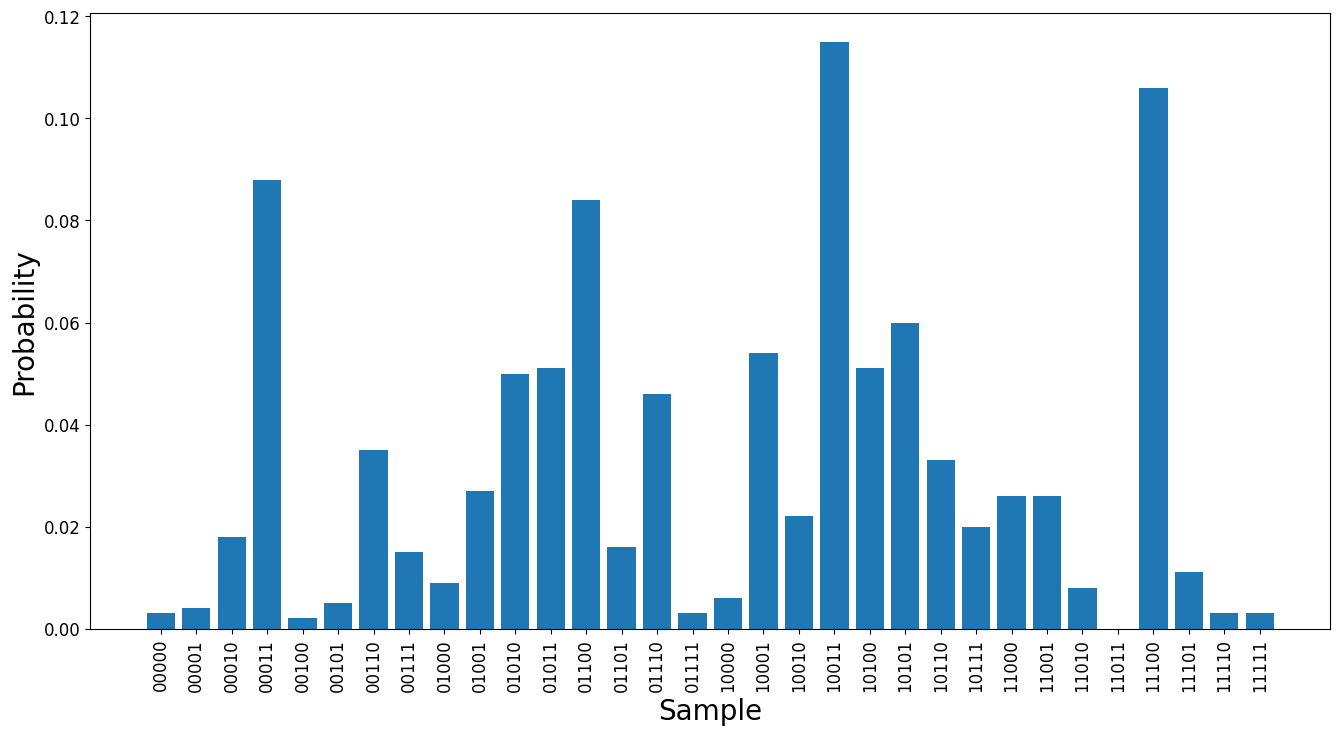

In [11]:
# 작업 결과에서 최적화된 파라미터를 가져옵니다
optimized_params = job_result['parameters']

# 양자 회로에서 측정된 결과로부터 계산된 확률 분포를 가져옵니다
sampled_probs = job_result['sampled probs']

# 샘플링된 확률의 키(결과 레이블)를 가져와 labels 변수에 저장합니다. 이 레이블은 바 차트의 x축에 표시됩니다
labels = sampled_probs.keys()

# plt.bar() 함수는 바 차트를 생성합니다. x축은 샘플의 인덱스(0부터 시작하는 정수), y축은 각 샘플의 확률 값
plt.bar(range(len(sampled_probs)), sampled_probs.values())
# plt.xticks()는 x축의 눈금을 설정, rotation='vertical'은 레이블을 세로 방향으로 회전시켜 가독성을 높입니다.
plt.xticks([i for i in range(len(sampled_probs))], labels, rotation='vertical', size=12)
plt.yticks(size=12)
plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

# 그래프 크기 설정 및 표시
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

Bitstring 10011 measured with probability 0.115 corresponding to the set


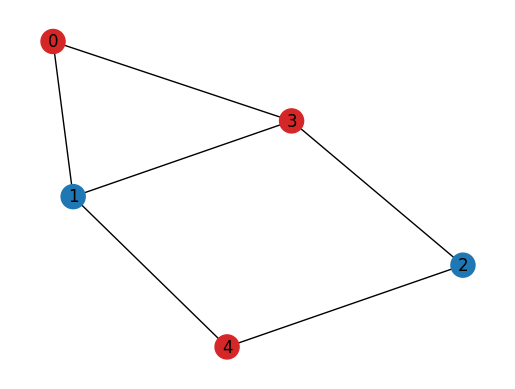

Bitstring 11100 measured with probability 0.106 corresponding to the set


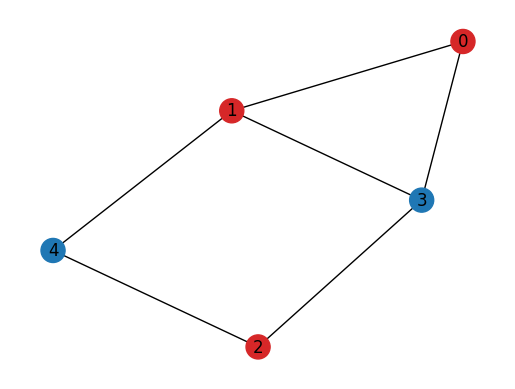

Bitstring 00011 measured with probability 0.088 corresponding to the set


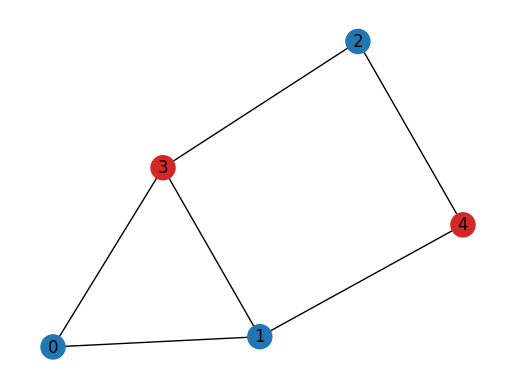

Bitstring 01100 measured with probability 0.084 corresponding to the set


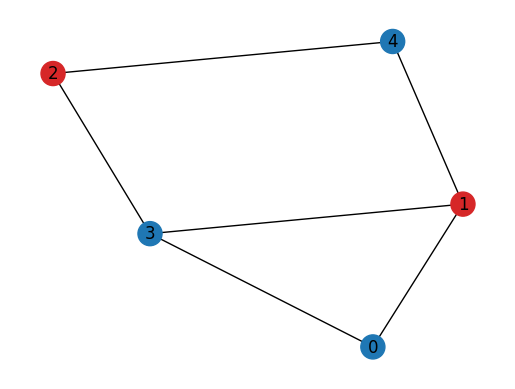

Bitstring 10101 measured with probability 0.06 corresponding to the set


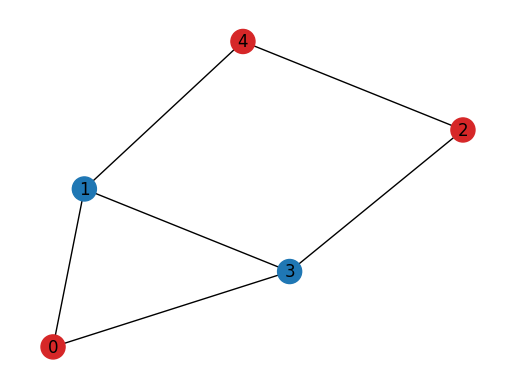

In [12]:
# 가장 높은 확률을 가진 비트 문자열 몇 개만 선택하는 데 사용
from itertools import islice

# sampled_probs.items()는 샘플링된 확률의 키-값 쌍을 반환
# sorted() 함수는 이 쌍을 확률 값(즉, 두 번째 요소) 기준으로 내림차순으로 정렬
sorted_probs = sorted(sampled_probs.items(), key=lambda x:x[1], reverse=True)
#시각화할 비트 문자열의 수를 설정합니다. 여기서는 상위 5개를 선택합니다
n_graphs_to_draw = 5

# 상위 비트 문자열과 확률을 시각화
for key, value in islice(sorted_probs, n_graphs_to_draw):
    fig, ax = plt.subplots()
    color_map = []
    for idx, val in enumerate(key):
        if val == '1':
            color_map.append('tab:red')
        else:
            color_map.append('tab:blue')
    print(f'Bitstring {key} measured with probability {value} corresponding to the set')
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()

## Running on a Braket Backend

So far, we've been simulating the quantum tasks in the algorithm with a local simulator running in the hybrid jobs container. The only thing we need to change when we want to run the quantum tasks on a Braket backend (on-demand simulator or QPU) instead, is to update the `device_arn` referenced in the `@hybrid_job` decorator above. In this case, the Braket SDK will create `AwsQuantumTask` instances with their state following a lifecycle from `CREATED`, `QUEUED`, `RUNNING`, to `COMPLETED` - similarly to the job state itself.

<div align="center">
<img src="images/job_hybrid.png" width="1000"/>
</div>

<div class="alert alert-block alert-warning"> <b>Note:</b> There are a few things to keep in mind when running on a Braket backend:
    
<ul>
  <li>Additional charges incur for the chosen Braket backend. Braket on-demand simulators are charged based on execution time, QPUs are charged based on the number of shots and tasks. See the <a href='https://aws.amazon.com/braket/pricing/'>Braket pricing</a> for more information.</li>
  <li>For that reason, it's recommended to estimate the number of quantum tasks your variational algorithm will create per iteration before you submit the entire optimization job. This number also depends also on how you calculate the gradients for your cost function.</li>
  <li>If you want to run on a QPU, verify if the selected QPU can process your circuit (qubit connectivity, supported gate operations, etc.).</li>
</ul>
</div>

위에 코드에서는 양자 디바이스로 로컬 시뮬레이터를 선택, 여기서는 SV1을 사용

변경해야 할 유일한 사항은 위의 @hybrid_job 데코레이터에서 참조한 device_arn을 업데이트하는 것

In [15]:
from braket.devices import Devices


@hybrid_job(
    device=Devices.Amazon.SV1,
    input_data=input_file_path,
    include_modules="maxcut_qaoa"
)
def qaoa_maxcut_pennylane(p=2, max_parallel=25, num_iterations=20, step_size=0.01, shots=1000):
    print(f"{get_job_name()} execution started")
    cost_tracker = Tracker().start()

    # Read graph from input file
    input_dir = get_input_data_dir()
    g = nx.read_adjlist(f"{input_dir}/graph.adjlist", nodetype=int)
    print(f"Graph loaded: {g}")

    # Instantiate device
    device = get_device_instance(
        get_job_device_arn(),
        n_wires=len(g.nodes),
        n_shots=shots,
        max_parallel=max_parallel
    )

    # Run algorithm
    optimized_parameters, sampled_probs = run_qaoa(
        graph=g,
        device=device,
        p=p,
        n_iterations=num_iterations,
        step_size=step_size
    )

    # Draw graph to an output file
    output_dir = get_results_dir()
    nx.draw(g, with_labels=True, node_size=600)
    plt.savefig(f"{output_dir}/graph.png")

    cost_tracker.stop()

    return {
        "parameters": optimized_parameters.tolist(),
        "sampled probs": sampled_probs,
        "quantum task summary": cost_tracker.quantum_tasks_statistics(),
        "quantum task cost": cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost(),
    }


task_estimation_job = qaoa_maxcut_pennylane(num_iterations=1)
print(f"{task_estimation_job.arn} {task_estimation_job.state()}")

arn:aws:braket:us-east-1:013288819788:job/af0b0d7f-4bd3-4663-a98c-1ef4b3562e00 QUEUED


In [16]:
task_estimation_job.state()

'RUNNING'

In [18]:
task_estimation_job_metadata = task_estimation_job.metadata()
task_estimation_job_result = task_estimation_job.result()

print("Job Summary")
print(f"  Total number of quantum tasks: {task_estimation_job_result['quantum task summary'][task_estimation_job_metadata['deviceConfig']['device']]['tasks']}") 
print(f"  Total number of shots (all tasks): {task_estimation_job_result['quantum task summary'][task_estimation_job_metadata['deviceConfig']['device']]['shots']}")
print(f"  Billed quantum simulator execution duration (all tasks): {task_estimation_job_result['quantum task summary'][task_estimation_job_metadata['deviceConfig']['device']]['billed_execution_duration']}")
print(f"  Estimated cost for all quantum tasks in this job ($): {task_estimation_job_result['quantum task cost']}")
print(f"  Job instance execution time on {task_estimation_job_metadata['instanceConfig']['instanceType']}: {timedelta(milliseconds=task_estimation_job_metadata['billableDuration'])}")

Job Summary
  Total number of quantum tasks: {'COMPLETED': 47}
  Total number of shots (all tasks): 47000
  Billed quantum simulator execution duration (all tasks): 0:02:21
  Estimated cost for all quantum tasks in this job ($): 0.1762500000
  Job instance execution time on ml.m5.large: 0:01:39
